In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os
import scipy as scipy
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import networkx as nx
import igraph
import glob

import bbknn

os.getcwd()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='Blues')
sc.logging.print_version_and_date()
sc.logging.print_header()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-uqp5lddp because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running Scanpy 1.6.0, on 2022-03-07 12:21.
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.8 louvain==0.7.0


In [4]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def subtraction(lst1, lst2): 
    lst3 = [value for value in lst1 if not value in lst2] 
    return lst3

### Importing data

In [5]:
adata = sc.read('/mnt/Science_revision/write/TICA_merged_singlets_immune.h5ad')

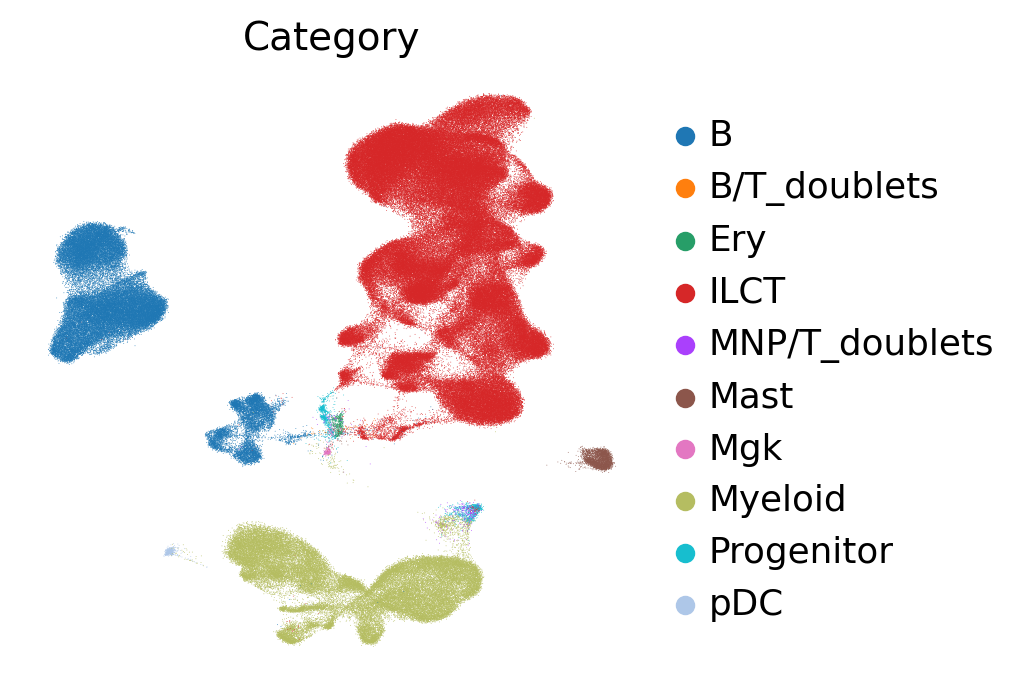

In [6]:
sc.pl.umap(adata, color='Category', frameon=False)

#### Subsetting the myeloid compartment

In [5]:
adata.X.min()

-2.3022542983229757

In [6]:
adata.raw.X.min()

0.0

In [7]:
adata = adata.raw.to_adata()

In [8]:
adata.X.min()

0.0

In [9]:
del adata.raw

In [10]:
adata=adata[adata.obs['Category'].isin(['Myeloid']),:]

In [11]:
adata.raw = adata
sc.pp.highly_variable_genes(adata, subset=True)
sc.pp.scale(adata, max_value=10)

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [12]:
bbknn.ridge_regression(adata, batch_key=['chem'], confounder_key=['new_predicted_labels'])

computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:02)


In [13]:
sc.pp.pca(adata)
bbknn.bbknn(adata, batch_key='donor_id')
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:12)


In [14]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:31)


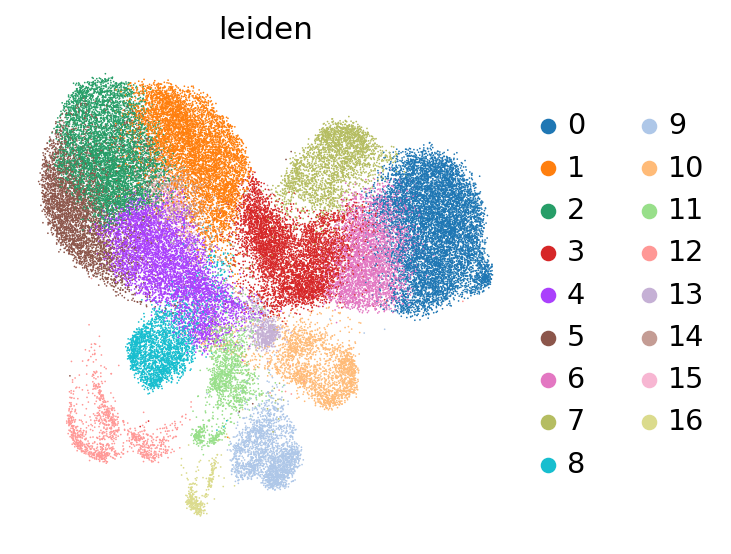

In [28]:
sc.pl.umap(adata, color=['leiden'], frameon=False)

In [16]:
adata.write('/mnt/Science_revision/write/TICA_myeloid.h5ad')

In [17]:
adata = sc.read('/mnt/Science_revision/write/TICA_myeloid.h5ad')

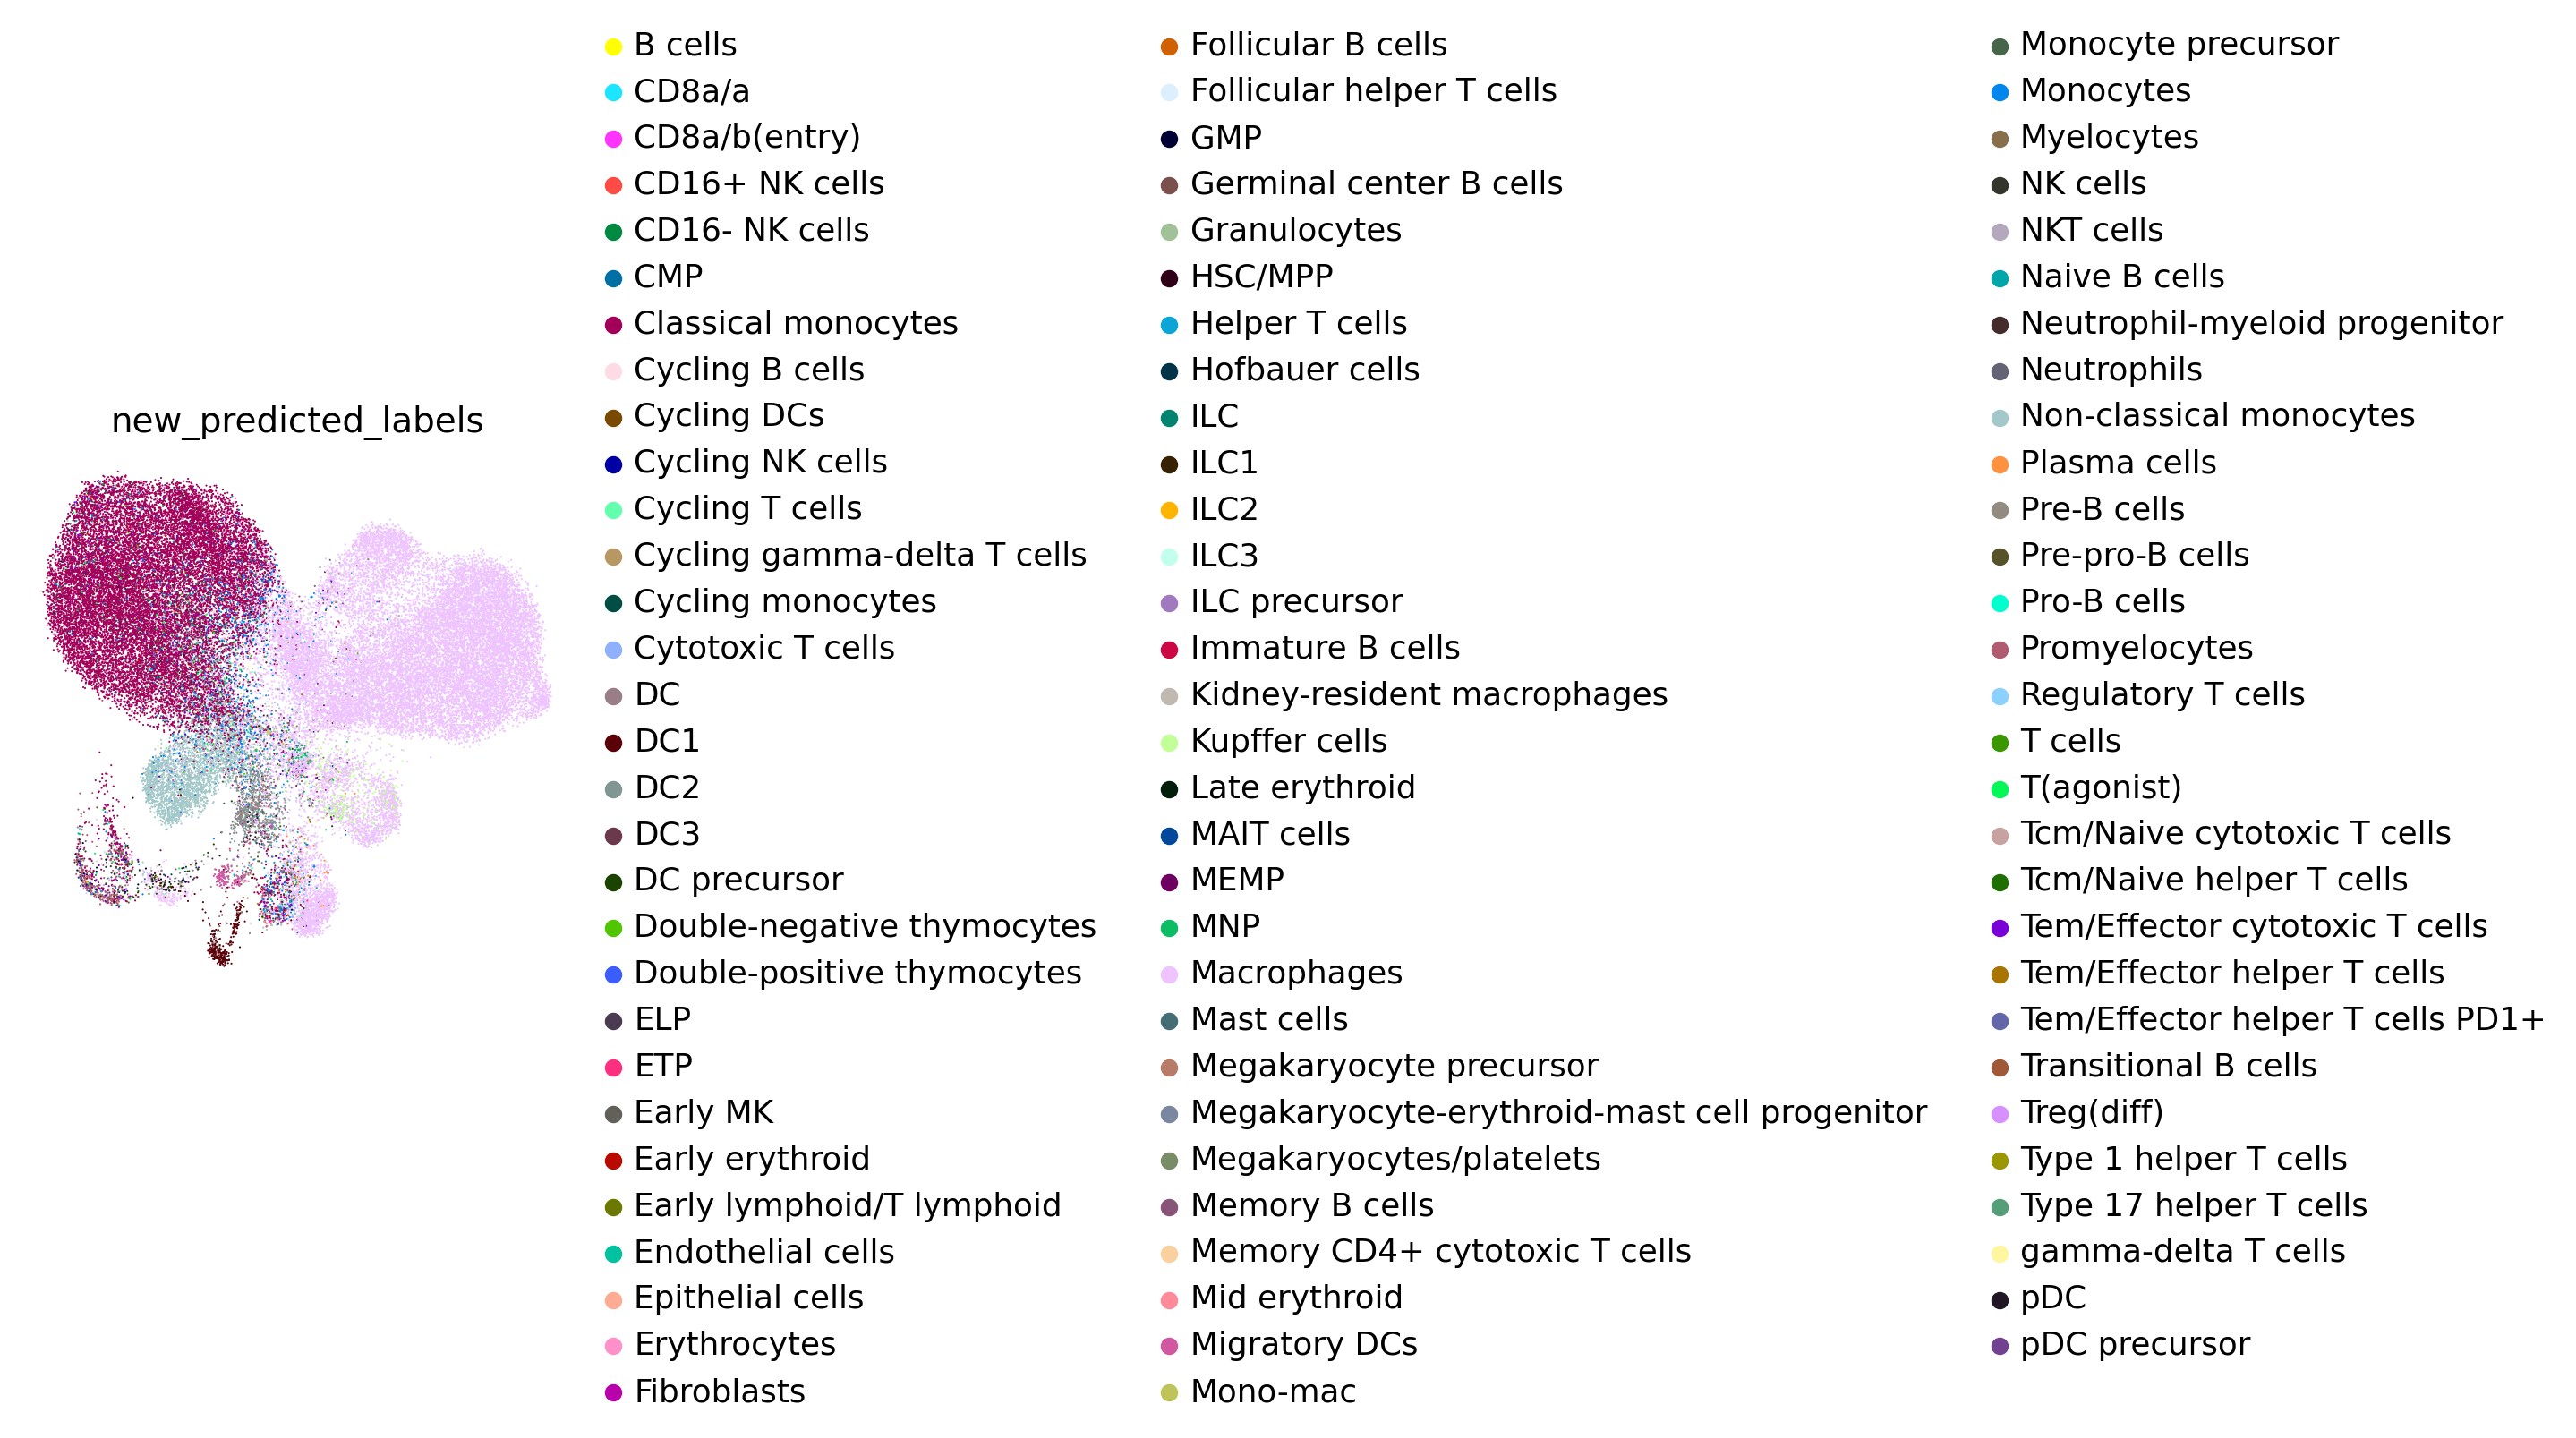

In [18]:
sc.pl.umap(adata, color=['new_predicted_labels'], frameon=False)

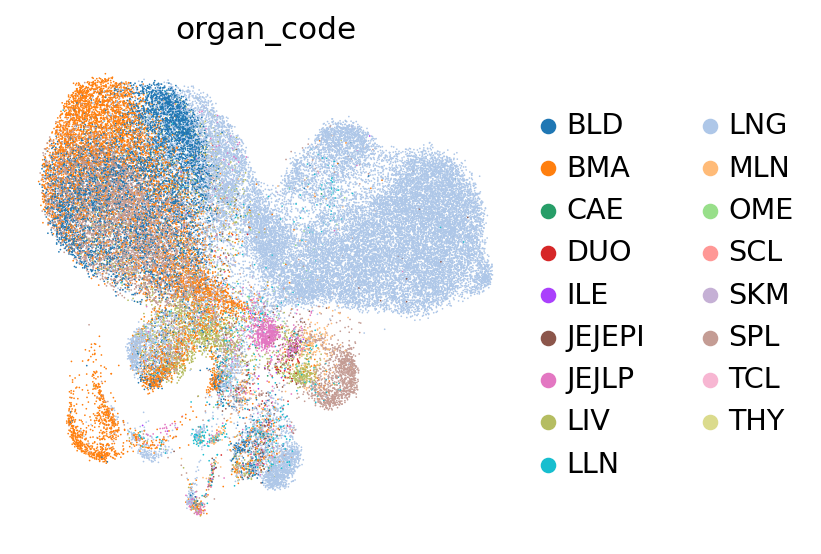

In [19]:
sc.set_figure_params(dpi_save=600)
sc.pl.umap(adata, color=['organ_code'], frameon=False, save='2C.pdf')

In [20]:
votes = pd.crosstab(adata.obs['new_predicted_labels'], adata.obs['leiden'])
majority = votes.idxmax()
adata.obs['new_predicted_labels_maj'] = majority[adata.obs['leiden'].values].values

... storing 'new_predicted_labels_maj' as categorical


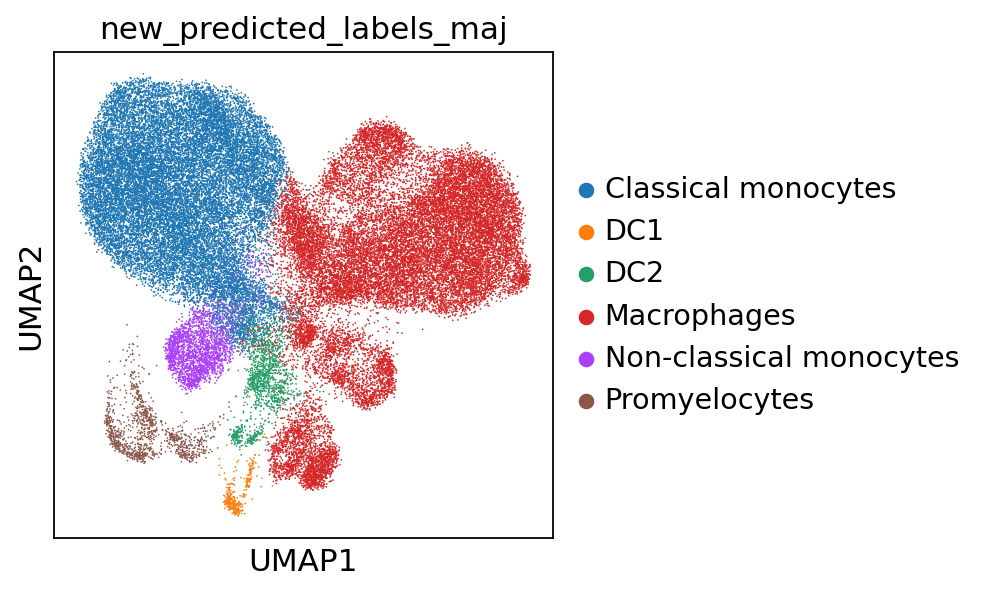

In [21]:
sc.pl.umap(adata, color=['new_predicted_labels_maj'])

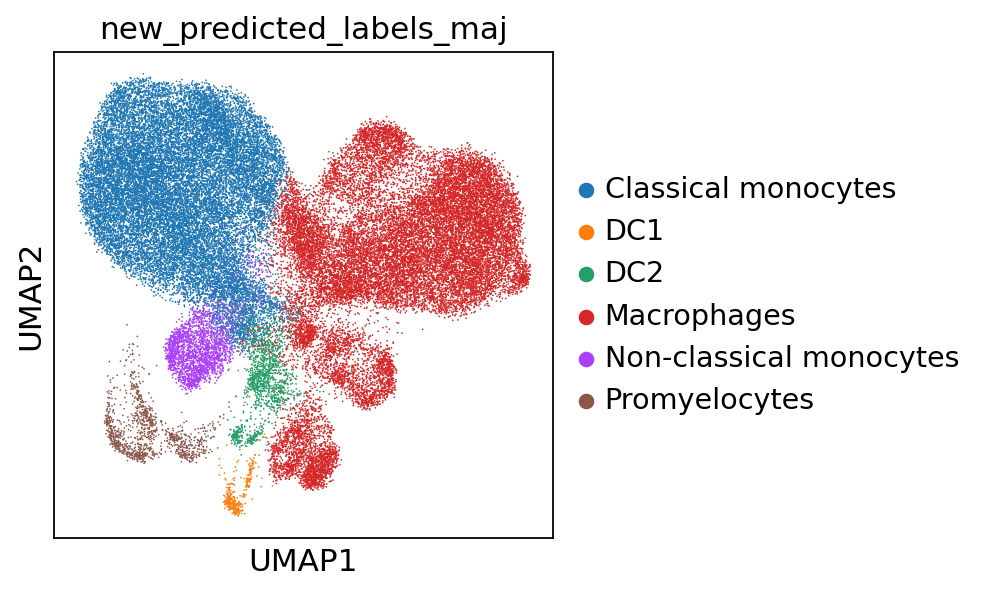

In [22]:
sc.pl.umap(adata, color=['new_predicted_labels_maj'])

In [23]:
sc.tl.leiden(adata, resolution=20, key_added='leiden_20')

running Leiden clustering
    finished: found 290 clusters and added
    'leiden_20', the cluster labels (adata.obs, categorical) (0:01:27)


In [24]:
votes = pd.crosstab(adata.obs['new_predicted_labels'], adata.obs['leiden_20'])
majority = votes.idxmax()
adata.obs['new_predicted_labels_maj20'] = majority[adata.obs['leiden_20'].values].values

... storing 'new_predicted_labels_maj20' as categorical


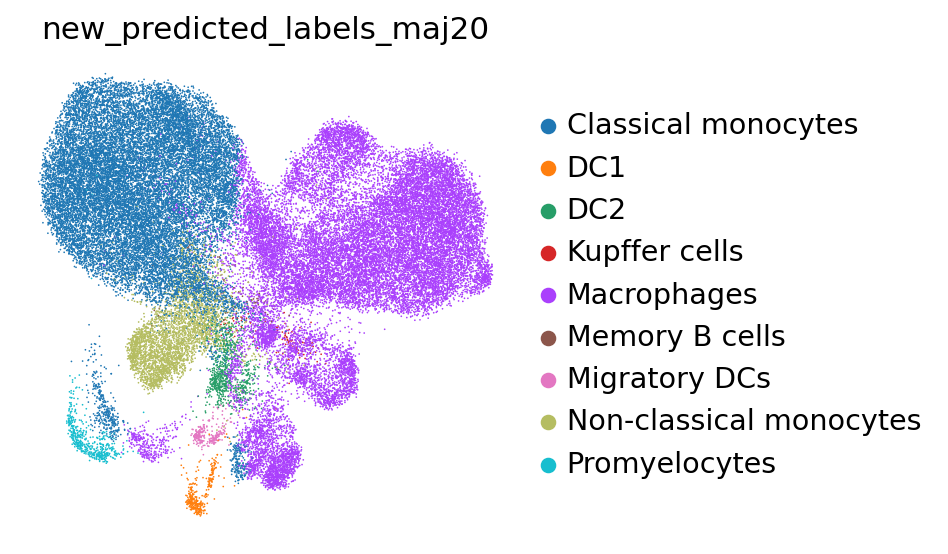

In [25]:
sc.pl.umap(adata, color=['new_predicted_labels_maj20'], frameon=False)

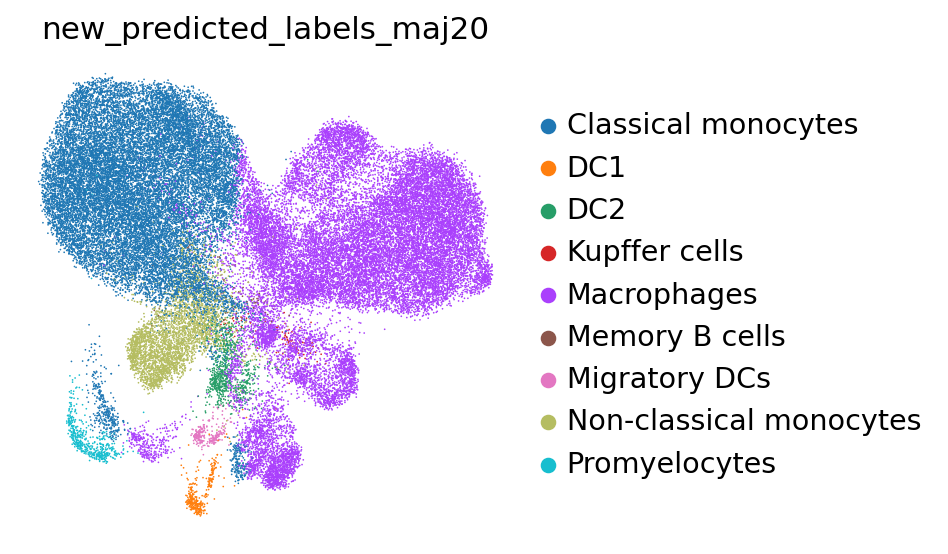

In [26]:
sc.pl.umap(adata, color=['new_predicted_labels_maj20'], frameon=False)

## Marker genes

In [29]:
sc.tl.rank_genes_groups(adata, groupby='leiden',method='wilcoxon',pts=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:33)


In [30]:
pts = adata.uns['rank_genes_groups']['pts']
pts_rest = adata.uns['rank_genes_groups']['pts_rest']

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

res = pd.DataFrame(index=range(0, pts.shape[0]))
for group in groups:
    df = pd.DataFrame({group + '_' + key: result[key][group] for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
    df[group+'_pts'] = pts.loc[df[group + '_names'], group].values
    df[group+'_pts_rest'] = pts_rest.loc[df[group + '_names'], group].values
    res = res.join(df)


In [31]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.5) & (sub_res['pts_rest'] < 0.3)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('mye_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [32]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.15) & (sub_res['pts_rest'] < 0.08)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('mye_low_exp_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [33]:
output.head(10)

names  pvals  pvals_adj  logfoldchanges       pts  pts_rest celltype
83         MME    0.0        0.0        4.746597  0.708015  0.030115        0
91        MYO6    0.0        0.0        3.989326  0.718034  0.047674        0
105      FFAR4    0.0        0.0        3.412941  0.731512  0.073643        0
116  LINC02185    0.0        0.0        3.746812  0.702886  0.060207        0
119       GPD1    0.0        0.0        4.668231  0.666388  0.026038        0
127     ATP10A    0.0        0.0        3.651898  0.692748  0.056361        0
131      ADTRP    0.0        0.0        3.902338  0.677839  0.043064        0
151      MACC1    0.0        0.0        3.851377  0.659590  0.051566        0
152    EPB41L1    0.0        0.0        3.428923  0.670444  0.060878        0
154       RND3    0.0        0.0        4.572941  0.653030  0.057172        0

In [34]:
mye_dict = {'10':'Erythrophagocytic macrophages',
 '11':'DC2/migDC',
 '16':'DC1',
 '3':'Lung macrophages',
 '0':'Lung macrophages',
 '7':'Lung macrophages',
 '1':'Classical monocytes',
 '4':'Classical monocytes',
 '8':'Nonclassical monocytes',
 '12':'Cycling',
 '9':'MNP/T doublets',
 '2':'Classical monocytes',
 '6':'Lung macrophages',
 '14':'Classical monocytes',
 '5':'Classical monocytes',
 '13':'CD209+SLC40A1+ macrophages',
 '15':'Classical monocytes'}

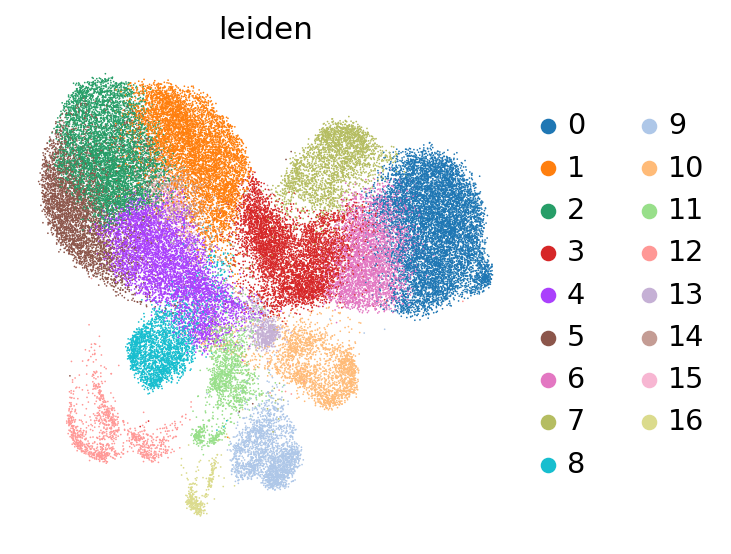

In [35]:
sc.pl.umap(adata, color=['leiden'], frameon=False)

In [36]:
adata.obs['anno_myeloid'] = adata.obs['leiden'].map(mye_dict)

In [37]:
sc.set_figure_params(dpi=100)

... storing 'anno_myeloid' as categorical


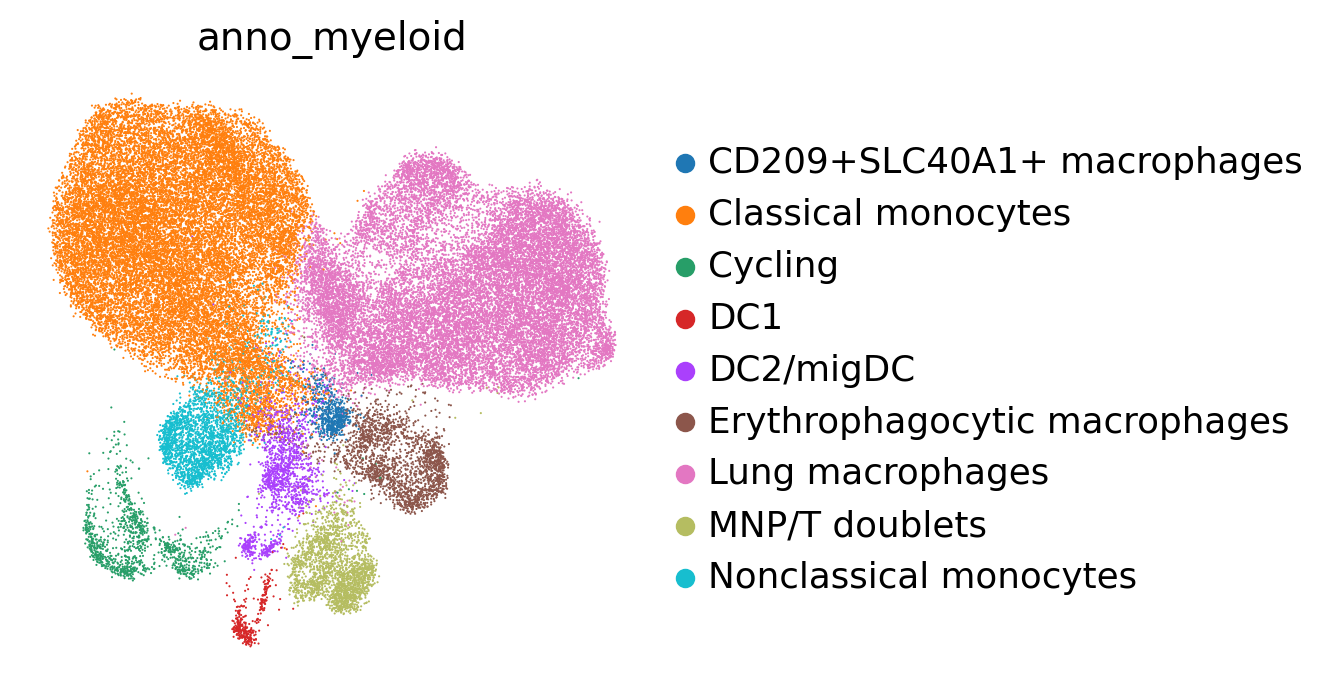

In [38]:
sc.pl.umap(adata, color=['anno_myeloid'], frameon=False)

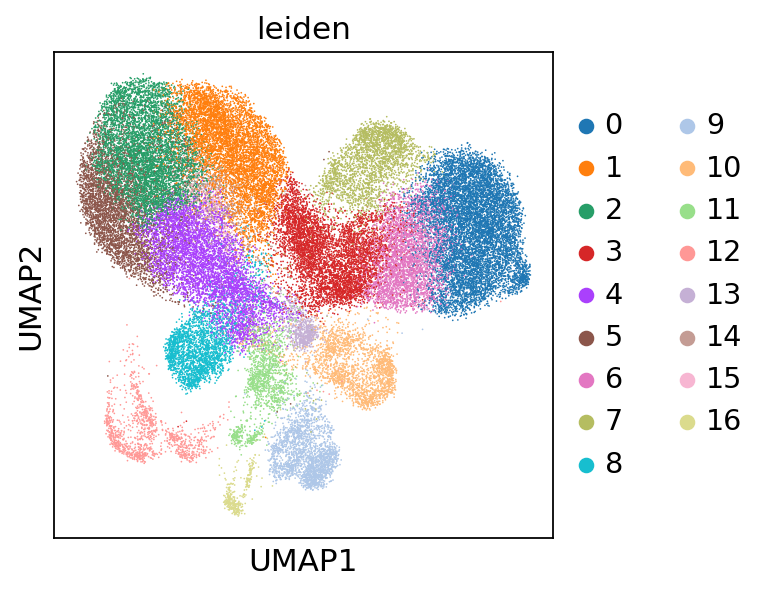

In [40]:
sc.pl.umap(adata, color=['leiden'])

In [41]:
sc.tl.leiden(adata, restrict_to=('leiden', ['11']), key_added='leiden_sub11', resolution=0.1)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden_sub11', the cluster labels (adata.obs, categorical) (0:00:00)


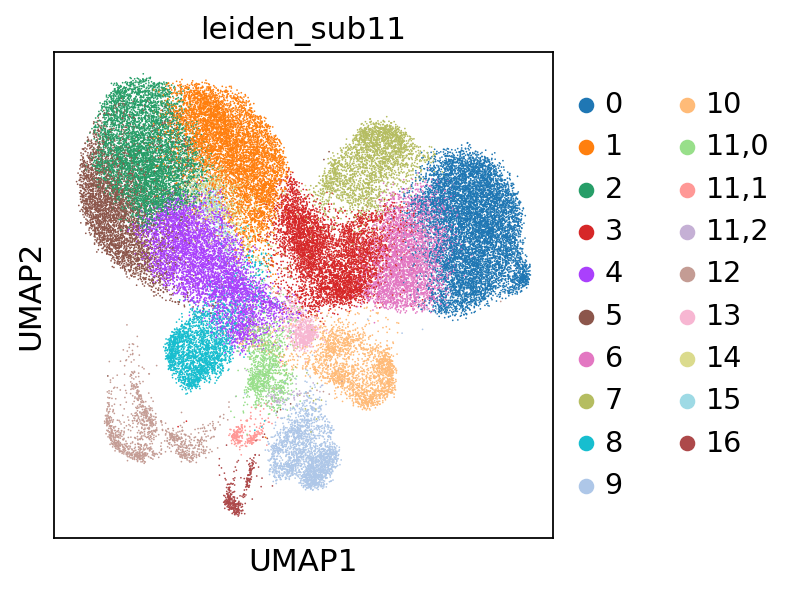

In [42]:
sc.pl.umap(adata, color=['leiden_sub11'])

In [43]:
sc.tl.leiden(adata, restrict_to=('leiden_sub11', ['3']), key_added='leiden_sub11_sub3', resolution=0.4)

running Leiden clustering
    finished: found 21 clusters and added
    'leiden_sub11_sub3', the cluster labels (adata.obs, categorical) (0:00:00)


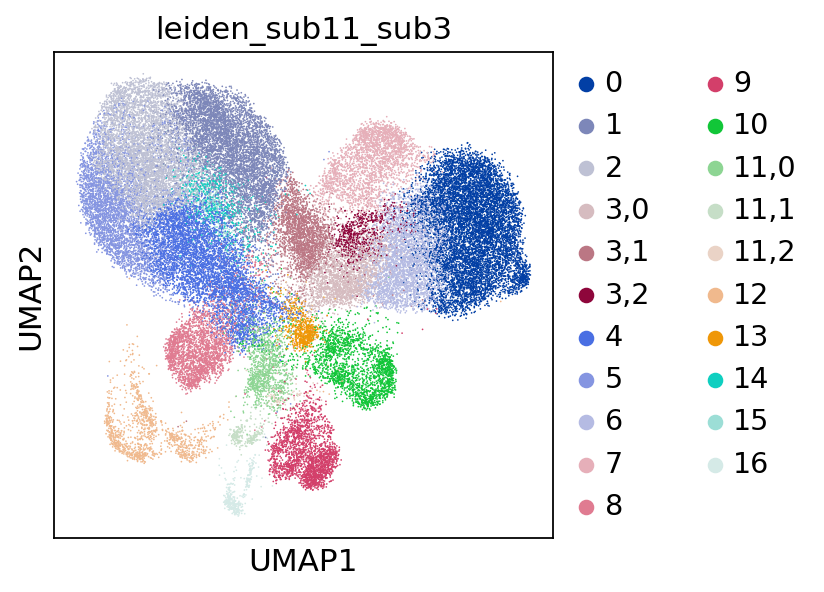

In [44]:
sc.pl.umap(adata, color=['leiden_sub11_sub3'])

In [45]:
mye_dict = {'10':'Erythrophagocytic macrophages',
 '11,0':'DC2',
            '11,2':'DC2',
'11,1':'migDC',
 '16':'DC1',
 '3,0':'Alveolar macrophages',
             '3,1':'Intermediate macrophages',
             '3,2':'Alveolar macrophages',
 '0':'Alveolar macrophages',
 '7':'Alveolar macrophages',
 '1':'Classical monocytes',
 '4':'Classical monocytes',
 '8':'Nonclassical monocytes',
 '12':'Cycling',
 '9':'MNP/T doublets',
 '2':'Classical monocytes',
 '6':'Alveolar macrophages',
 '14':'Classical monocytes',
 '5':'Classical monocytes',
 '13':'Intestinal macrophages',
 '15':'Classical monocytes'}

In [46]:
adata.obs['anno_myeloid'] = adata.obs['leiden_sub11_sub3'].map(mye_dict)

... storing 'anno_myeloid' as categorical


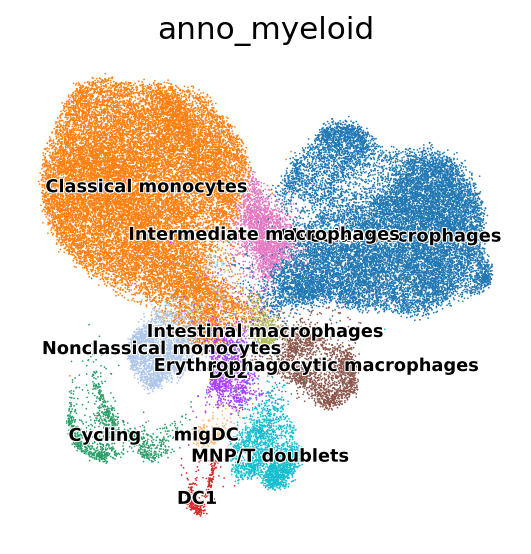

In [47]:
sc.set_figure_params(dpi_save=600)
sc.pl.umap(adata, color=['anno_myeloid'], frameon=False, legend_loc='on data', legend_fontoutline=1, legend_fontsize=8, save='2A.pdf')

In [48]:
adata.write('/mnt/Science_revision/write/TICA_myeloid.h5ad')

# Markers for final annotated clusters

In [49]:
sc.tl.rank_genes_groups(adata, groupby='anno_myeloid',method='wilcoxon',pts=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:14)


In [50]:
pts = adata.uns['rank_genes_groups']['pts']
pts_rest = adata.uns['rank_genes_groups']['pts_rest']

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

res = pd.DataFrame(index=range(0, pts.shape[0]))
for group in groups:
    df = pd.DataFrame({group + '_' + key: result[key][group] for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
    df[group+'_pts'] = pts.loc[df[group + '_names'], group].values
    df[group+'_pts_rest'] = pts_rest.loc[df[group + '_names'], group].values
    res = res.join(df)


In [51]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.5) & (sub_res['pts_rest'] < 0.3)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('anno_mye_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [52]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.15) & (sub_res['pts_rest'] < 0.08)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('anno_mye_low_exp_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [53]:
output.head(10)

names  pvals  pvals_adj  logfoldchanges       pts  pts_rest  \
9        NUPR1    0.0        0.0        5.320819  0.859845  0.064842   
32        GLDN    0.0        0.0        5.154602  0.757977  0.043335   
38     BHLHE41    0.0        0.0        5.250051  0.738775  0.038876   
45      PHLDA3    0.0        0.0        5.463917  0.721603  0.025850   
46  AC026369.3    0.0        0.0        5.166310  0.732045  0.048901   
47        AQP3    0.0        0.0        4.873306  0.736744  0.044559   
51      PDLIM1    0.0        0.0        4.327101  0.746374  0.064930   
52     S100A13    0.0        0.0        4.050116  0.753916  0.072419   
53    LGALS3BP    0.0        0.0        4.276298  0.749623  0.075800   
66      FRMD4A    0.0        0.0        3.660227  0.723750  0.054176   

                celltype  
9   Alveolar macrophages  
32  Alveolar macrophages  
38  Alveolar macrophages  
45  Alveolar macrophages  
46  Alveolar macrophages  
47  Alveolar macrophages  
51  Alveolar macrophages  
52  Alveolar macrophages  
53  Alveolar macrophages  
66  Alveolar macrophages

In [54]:
list(adata.obs['anno_myeloid'].unique())

['Erythrophagocytic macrophages',
 'DC2',
 'DC1',
 'Intermediate macrophages',
 'Alveolar macrophages',
 'Classical monocytes',
 'Nonclassical monocytes',
 'Cycling',
 'migDC',
 'MNP/T doublets',
 'Intestinal macrophages']

In [55]:
ct_order = ['DC1', 'DC2',
 'migDC',
 
 'Classical monocytes',
 'Nonclassical monocytes','Alveolar macrophages','Intermediate macrophages','Intestinal macrophages','Erythrophagocytic macrophages',
 
  'Cycling',
 'MNP/T doublets']

In [56]:
top_mks = ['CD74','HLA-DRA','CLEC9A',
 'DNASE1L3',
 'IDO1','XCR1',
 'CLEC10A',
 'CD1C',
 'PKIB',
 'FSCN1',
 'LAMP3',
 'CCR7',
           'CD14','FCGR3A','C1QA',
 'CRISPLD2',
 'CLU',
 'MARC1',
 'CDKN1C',
 'ZNF703',
 'CX3CR1',
 'GPNMB',
 'TREM2',
 'BHLHE41',
 'TNIP3',
           'CCL2',
 'SPP1',
 
 'SELENOP',
 'CD5L','SPIC','SLC40A1','VCAM1',
 'CXCL12',
 
 'CD209',
 'SDS','IGF1',
 'MKI67',
 
 'CD3E']

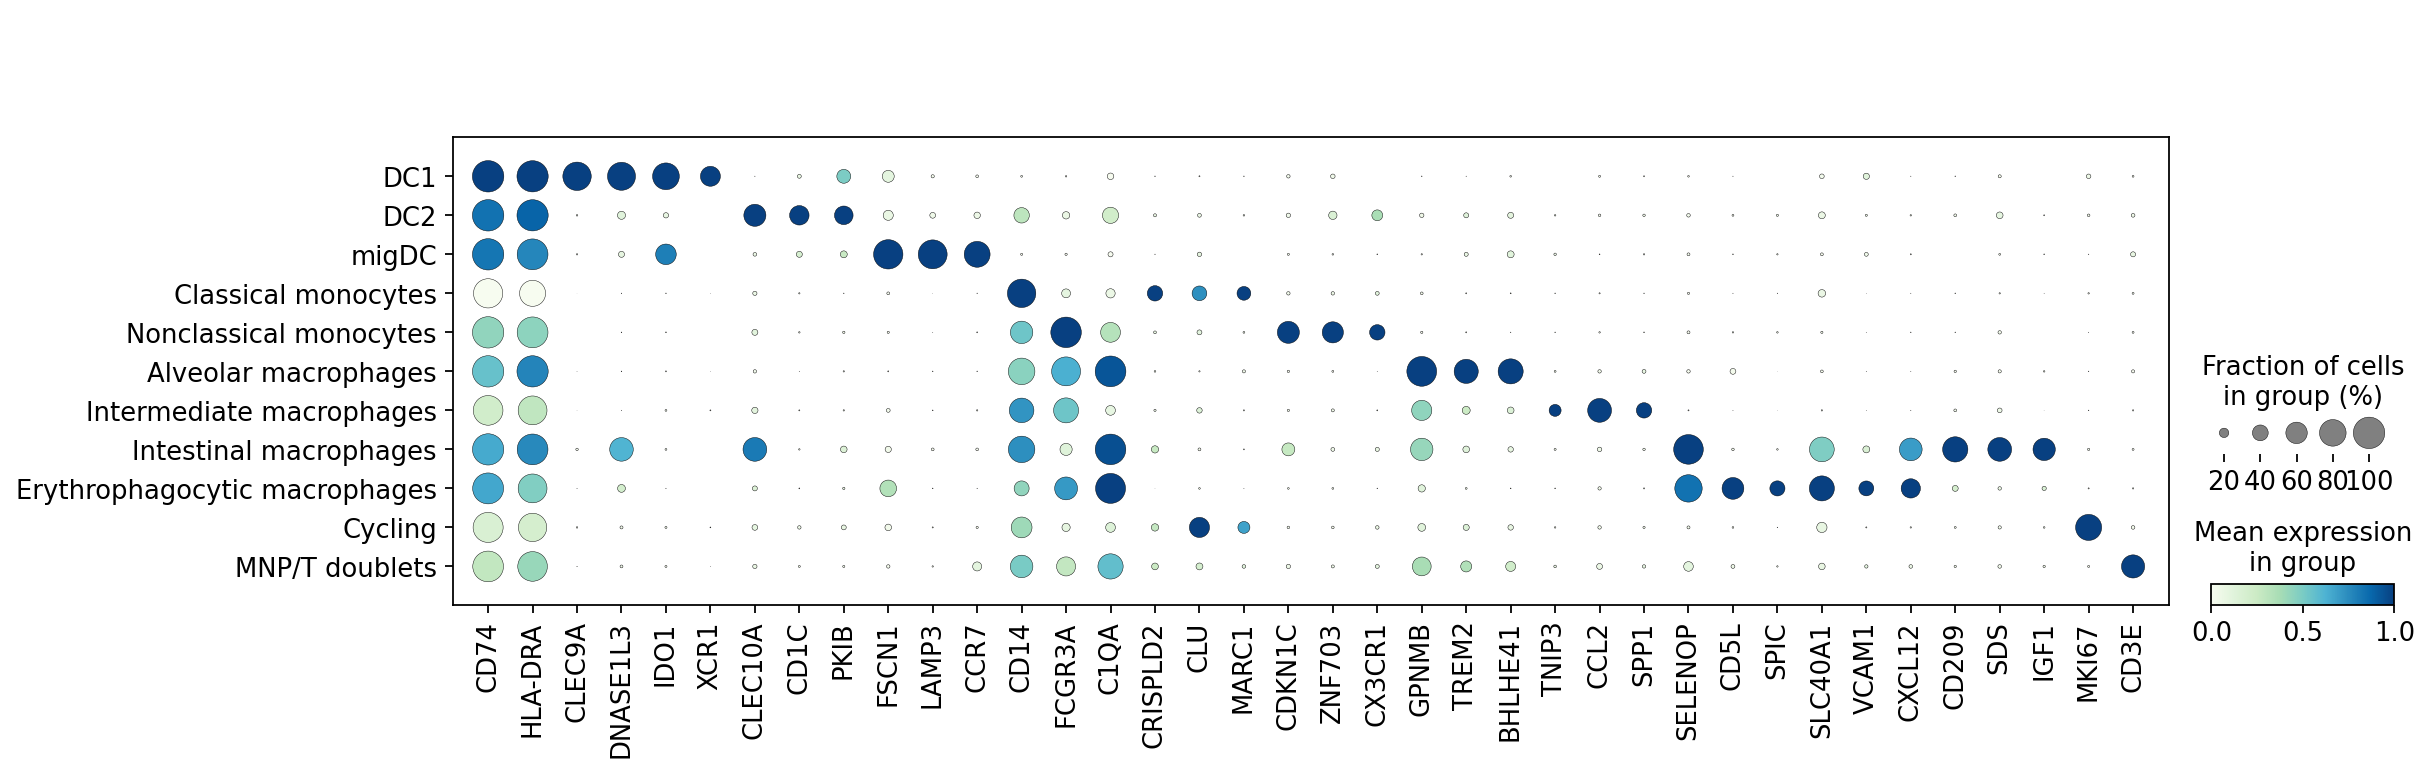

In [57]:
sc.settings.set_figure_params(dpi_save=600)
sc.pl.dotplot(adata, var_names=top_mks, groupby='anno_myeloid', standard_scale='var', cmap='GnBu', categories_order=ct_order, save='2B.pdf')

### Migratory DCs across tissues

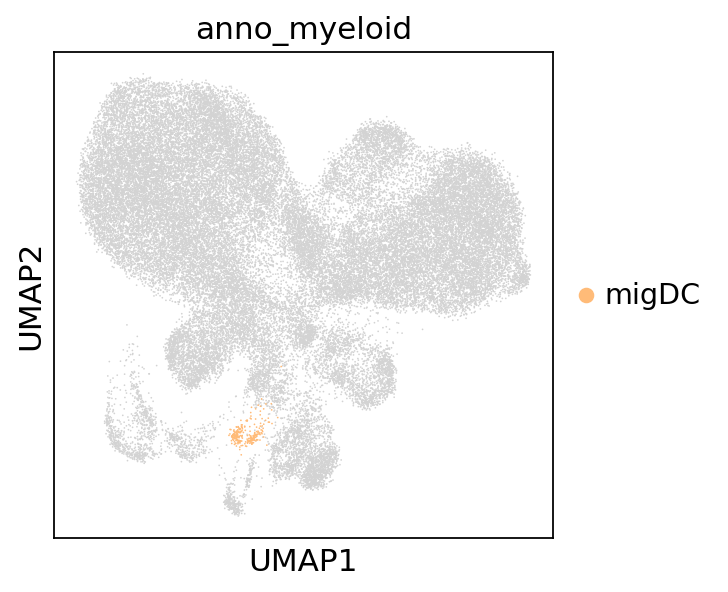

In [58]:
sc.pl.umap(adata, color='anno_myeloid', groups='migDC')

In [59]:
migDC = adata[adata.obs['anno_myeloid'] == 'migDC']

In [60]:
migDC.obs['organ_code'].value_counts()

LLN       95
LNG       84
MLN       48
SPL       19
JEJLP      8
JEJEPI     5
LIV        2
OME        1
Name: organ_code, dtype: int64

<AxesSubplot:title={'center':'migDC'}>

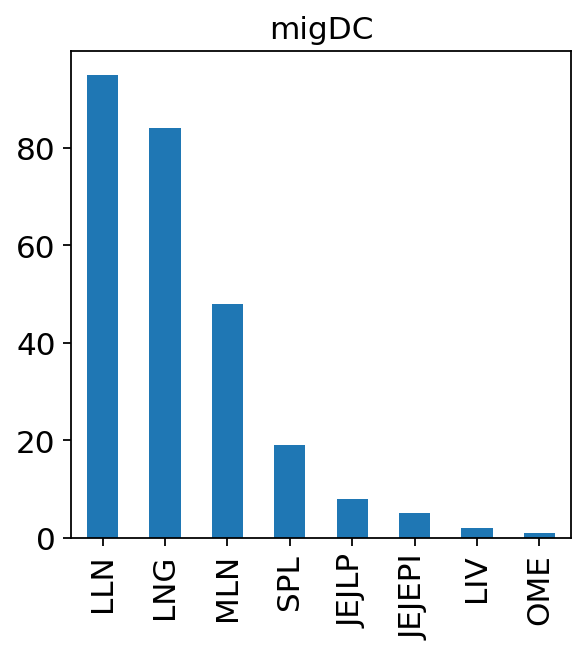

In [61]:
migDC.obs['organ_code'].value_counts().plot(kind='bar', grid=False, title='migDC')

In [62]:
list(migDC.obs['organ_code'].unique())

['LNG', 'LLN', 'MLN', 'SPL', 'OME', 'JEJLP', 'LIV', 'JEJEPI']

In [63]:
migDC_subset = migDC[migDC.obs['organ_code'].isin(['LNG','MLN','LLN'])]

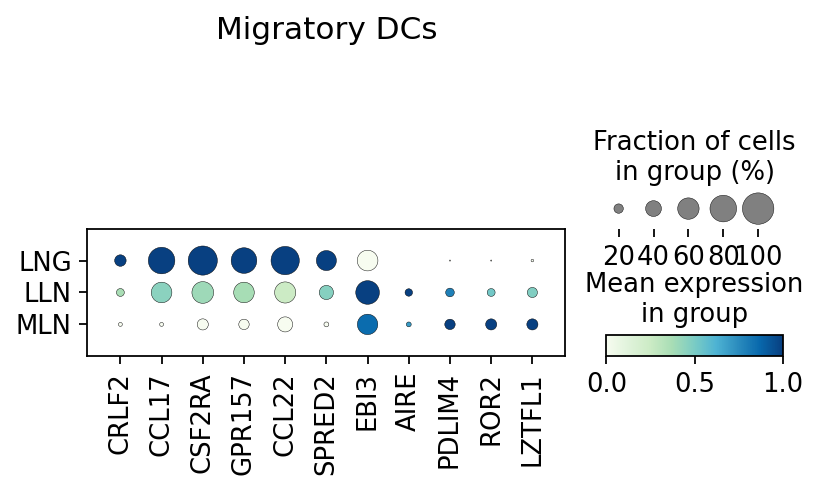

In [64]:
sc.pl.dotplot(migDC_subset, var_names=['CRLF2','CCL17','CSF2RA','GPR157','CCL22','SPRED2','EBI3','AIRE','PDLIM4','ROR2','LZTFL1'], groupby='organ_code',title='Migratory DCs',  cmap='GnBu', standard_scale='var', categories_order=['LNG','LLN','MLN'])

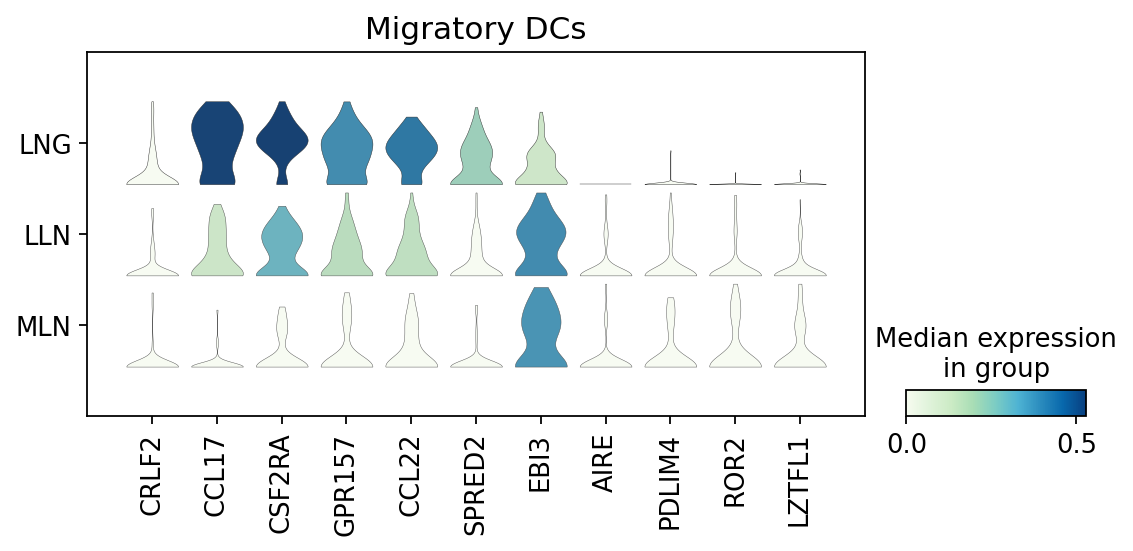

In [65]:
sc.pl.stacked_violin(migDC_subset, var_names=['CRLF2','CCL17','CSF2RA','GPR157','CCL22','SPRED2','EBI3','AIRE','PDLIM4','ROR2','LZTFL1'], figsize=(8,3), groupby='organ_code',title='Migratory DCs',  cmap='GnBu', standard_scale='var', categories_order=['LNG','LLN','MLN'])